# Building Micrograd

## Micrograd overview

Micrograd is a small library that helps us implement auto-grad or automatic differentiation. Auto-grad internally helps us do backpropagation in any deep neural network. Backpropagation is the process of computing the gradient of the loss function with respect to the parameters of the network. Lets assume that the gradient of the loss function is a scalar value of 185. What this means is that suppose I change my parameters, then the loss function will change at a rate where the slope of the hyperplane is 185. Micrograd will work on scalar values, but in deep learning, we deal with tensors. Tensors are nothing but scalar values wrapped in arrays and with tensors we can use the computer's parallelism to do auto-grad.

## Understanding Derivatives

### Derivative of a simple function with 1 input

In [64]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

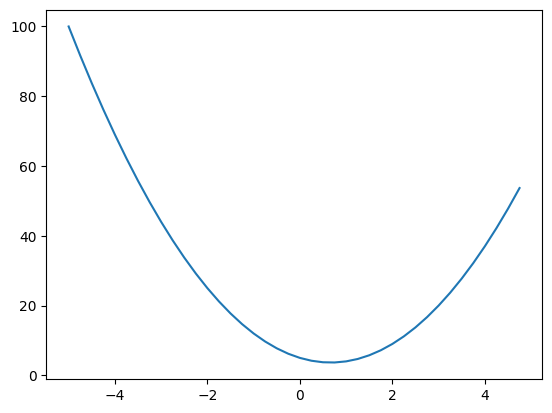

In [66]:
xs = np.arange(-5, 5, 0.25)
y = f(xs)
plt.plot(xs, y)

The definition of derivative is that suppose I change the value of x by a very small amount, how does my function respond to it or how sensitive is my function to the change in x? The sign tells us if the function is increasing or decreasing and the magnitude tells us how sensitive the function is to the change in x. Using limits, we can actually get the approximate value of the derivative at any point. For example, at x = 3, then derivative points in direction of increasing y and at -3, it points in direction of decreasing y. 
***Therefore -derivative is the direction of greatest descent.***

In [67]:
h = 0.001
x = 3.0
print((f(x + h) - f(x)) / h)

x = -3.0
print((f(x + h) - f(x)) / h)

x = 2/3
print((f(x + h) - f(x)) / h)

14.00300000000243
-21.996999999998934
0.0029999999995311555


### Derivative of function with multiple inputs

In [68]:
a = 2.0
b = -3.0
c = 10.0

def d(a, b, c):
    return a*b + c

print(d(a, b, c))

4.0


In the examples below, we can see that if we find the derivative of d wrt to a, then the value goes down. If we find the derivative of d wrt to b, then the value goes up. If we find the derivative of d wrt to c, then the value increases by the same amount as c. SO when a derivative is 1, it means that the value increases by the same amount as the variable.

In [69]:
h = 0.001

print(f"If we find the derivative of d wrt to a, we can see that the value goes down from {d(a, b, c):.8f} to {d(a + h, b, c):.8f}")
print('The slope is: ', (d(a + h, b, c) - d(a, b, c)) / h)

print(f"If we find the derivative of d wrt to b, we can see that the value goes up from {d(a, b, c):.8f} to {d(a, b + h, c):.8f}")
print('The slope is: ', (d(a, b + h, c) - d(a, b, c)) / h)

print(f"If we find the derivative of d wrt to c, we can see that the value stays same {d(a, b, c):.8f} to {d(a, b, c + h):.8f}")
print('The slope is: ', (d(a, b, c + h) - d(a, b, c)) / h)


If we find the derivative of d wrt to a, we can see that the value goes down from 4.00000000 to 3.99700000
The slope is:  -3.0000000000001137
If we find the derivative of d wrt to b, we can see that the value goes up from 4.00000000 to 4.00200000
The slope is:  1.9999999999997797
If we find the derivative of d wrt to c, we can see that the value stays same 4.00000000 to 4.00100000
The slope is:  0.9999999999994458


## Forward Pass

Now that we understand the basics of what derivatives are, we need to create the classes that will help us create shells of our variables. 

### Value Class

1. We create a data attribute to store the data
2. We create a _prev attribute to store the computation through which this value was generated.
3. We override the methods to allow us to use binary operators.
4. We create a _op attribute to store the operation that was performed to generate this value.
5. We can implement any function inside tanh as long as the function is differentiable with respect to the input.

In [70]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0
    
    # This is a special method that allows us to print the value
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    # These are special methods that allow us to use the + operator
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1.0

        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        for node in reversed(topo):
          node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a*b; d.label = 'd'
e = d + c; e.label = 'e'

f = Value(-2.0, label='f')
L = e * f; L.label = 'L'
print(e)


Value(data=4.0)


Below we define a simple function that creates a visualisation of our computational graph

In [71]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

This is the visualusation of what we call a forward pass. In forward pass, the values are computed and intermediate results are stored to be used later. In our example we are using scalar values and simple operations for simplicity, but even with complex values the idea remains exactly the same.

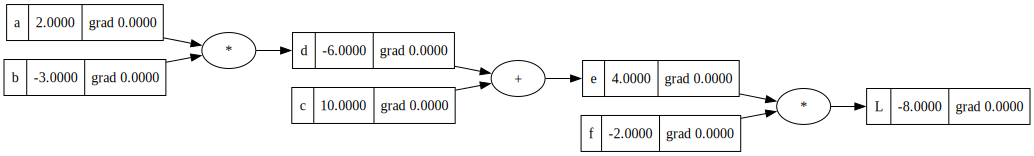

In [72]:
draw_dot(L)

## Backward Propogation

With backward propogation, what we want to do is that we want to compute the derivative of a loss function with respect to weights of the model. In our example, we want to compute the derivative of L with respect to a, b, c, d, e and f. Lets write an algorithm for the same.

### Manual Backpropogation

We can manually see that:

- dL/dL = 1 => This is always true.
- dL/de = -2
- dl/df = 4

Since e and f are the last node, backward propogation of this layer is easy. For other layers we use the chain rule. If we understand this, then we can understand most of what backpropogation is. We know how c impacts e and we know how e impacts L. Chain rule tells us that dL/dc = dL/de * de/dc which is just putting the 2 pieces of information together.

How do these derivative values help us? Well lets assume that we want to push the value of L towards 0, then we know that we need to change the values in the direction of the gradient. A single optimisation step actually is exactly this.

In [73]:
L.grad = 1
f.grad = 4
e.grad = -2
c.grad = -2
d.grad = -2
a.grad = 6.0
b.grad = -4.0

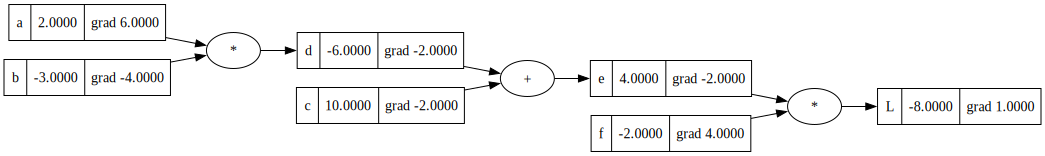

In [74]:
draw_dot(L)

Let us now take an example of a complex function and a neuron and see how backpropogation works. Lets think of just one neuron and how it

In [75]:
#Inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

#Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#Bias
b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

Now let us manually see what the derivative of o would be with respect to all the other variables.

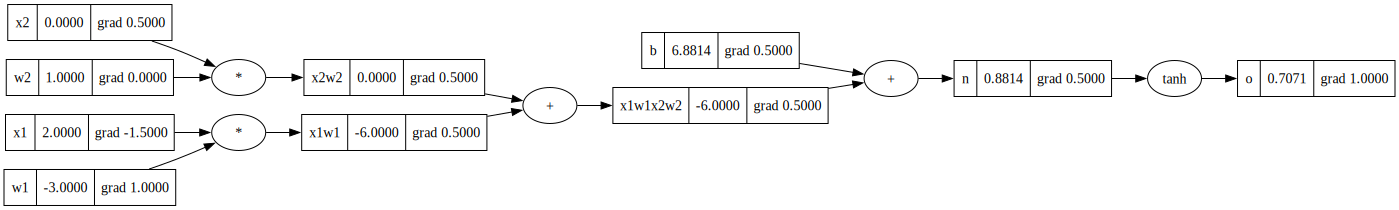

In [76]:
o.grad = 1.0
n.grad = 0.5 # derivative of tanh = 1 - tanh^2 = 1 - o^2 = 1 - (0.7071^2) = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x2w2.grad = 0.5
x1w1.grad = 0.5
x2.grad = 0.5
w2.grad = 0.0
x1.grad = -1.5
w1.grad = 1

draw_dot(o)

Obviously, we cannot do ANY of this manually. We need to implement backpropagation alogrithm for operations. In the class value, we have implemented the method called _backward for each operation that we can perform on value. Now we can use this to run backpropagation. We will make all the gradients zero and then implement the backprop.

In [77]:
o.grad = 1.0
n.grad = 0.0
x1w1x2w2.grad = 0.0
b.grad = 0.0
x2w2.grad = 0.0
x1w1.grad = 0.0
x2.grad = 0.0
w2.grad = 0.0
x1.grad = 0.0
w1.grad = 0.0

To make backpropogation work, we need to create a topologocialluy sorted DAG. Topological sort is a linear ordering of vertices such that for every directed edge uv, vertex u comes before v in the ordering. 

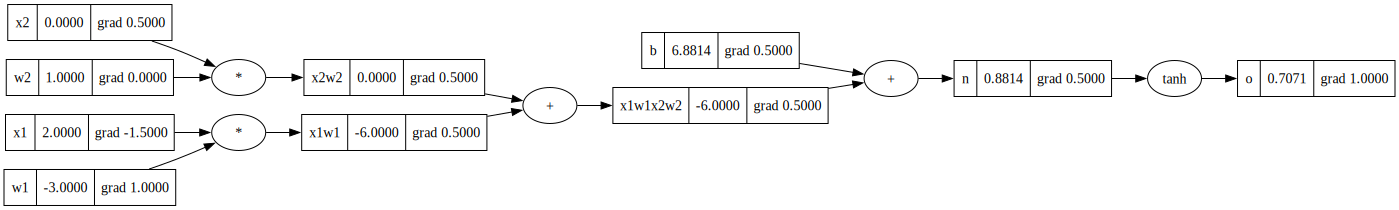

In [78]:
o.backward()

draw_dot(o)

There is a bug in the current implementation. In the current implementation suppose the same variable is used multiple times, it considers A as a new variable and not the same variable. The chain rule tells you that the gradient should be added up. So we make that change in the Value class.

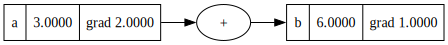

In [79]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)